# Regression Analysis

### Imports

In [122]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

CONSENSUS_TIME = 'consensus_time'
OPINION_CHANGE_FREQUENCY = 'opinion_change_frequency'

FEATURES = [
    'clustering', 
    'closeness', 
    'n'
]

UNCORRELATED_FEATURE_SUBSET = [
    'clustering', 
    'closeness',
    'assortativity',
    'shannon_entropy'
]

In [123]:
dataset = pd.read_csv('../data/dataset.csv')

In [124]:
filtered_dataset = dataset.copy()
filtered_dataset.describe()

,clustering,closeness,n,consensus_time,opinion_change_frequency,groups
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.0
mean,0.518071,0.697597,1259.989848,13.360355,312.219137,0.0
std,0.279386,0.141018,142.531987,25.570319,44.651281,0.0
min,0.019483,0.381968,1013.000000,1.430000,209.500000,0.0
25%,0.299717,0.588160,1146.000000,3.090000,276.150000,0.0
50%,0.518177,0.674908,1269.000000,5.350000,313.570000,0.0
75%,0.766184,0.810564,1387.000000,10.360000,343.690000,0.0
max,0.994529,0.994563,1493.000000,210.910000,488.420000,0.0


### Creating Scaler

In [125]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# dataset[FEATURES] = scaler.fit_transform(dataset[FEATURES])
# dataset[['consensus_time', 'opinion_change_frequency']] = scaler.fit_transform(dataset[['consensus_time', 'opinion_change_frequency']])

### Adjusted R2

In [126]:
from sklearn.metrics import r2_score

def adjusted_r2_score(y: np.array, y_hat: np.array, n: int, p: int):
    """
    Computes R² score. It decreases if many variables are introduced.
    n: number of observations in sample 
    p: number of independent variables
    """
    return 1 - ((1 - r2_score(y, y_hat)) * ((n - 1)/(n - p - 1)))

### Train Test Split

In [127]:
from sklearn.model_selection import train_test_split

# filtered_dataset.loc[:, FEATURES] = scaler.fit_transform(filtered_dataset[FEATURES])
# filtered_dataset.loc[:, 'opinion_change_frequency'] = scaler.fit_transform(np.array(filtered_dataset['opinion_change_frequency']).reshape(-1, 1))

y = filtered_dataset[CONSENSUS_TIME]
X = sm.add_constant(
   filtered_dataset[FEATURES]
)

X['clustering_log'] = np.log(X['clustering'])
FEATURES.append('clustering_log')

FEATURES.remove('closeness')
FEATURES.remove('n')
FEATURES.remove('clustering')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, shuffle=True
)

X_train[FEATURES] = scaler.fit_transform(X_train[FEATURES])
X_test[FEATURES] = scaler.transform(X_test[FEATURES])


## Linear

In [128]:
mod = sm.OLS(
    endog=np.log(y_train), 
    exog=sm.add_constant(X_train[FEATURES]),
)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         consensus_time   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 1.294e+04
Date:                Mon, 26 Aug 2024   Prob (F-statistic):          3.00e-151
Time:                        17:36:03   Log-Likelihood:                 134.52
No. Observations:                 157   AIC:                            -265.0
Df Residuals:                     155   BIC:                            -258.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.8371      0.008    222.

We still achieve a R-Squared of $0.99$ but without errors related to collinearity

In [129]:
y_pred = res.predict(sm.add_constant(X_test[FEATURES]))

In [130]:
adjusted_r2_score(y_pred, np.log(y_test), len(y_pred), len(UNCORRELATED_FEATURE_SUBSET))

0.9884303919902405

In [133]:
new_x = np.arange(-4,0, 0.01)
new_y = res.params['const'] + res.params['clustering_log'] * new_x

Text(0.5, 1.0, 'Power law in Sznajd Model simulation')

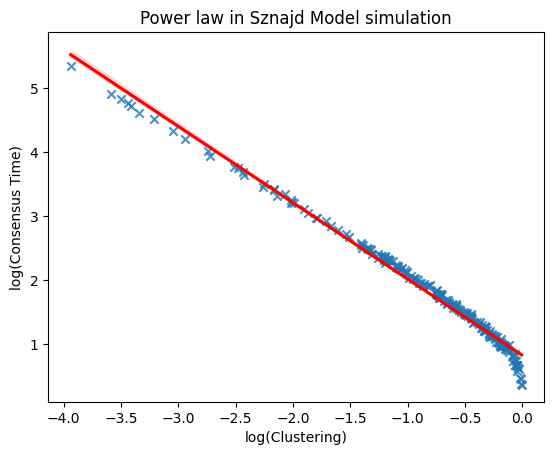

In [152]:
sns.regplot(x=np.log(X['clustering']), y=np.log(y), marker="x", line_kws=dict(color="r"))
plt.xlabel('log(Clustering)')
plt.ylabel('log(Consensus Time)')
plt.title('Power law in Sznajd Model simulation')

### Residuals

<Axes: ylabel='consensus_time'>

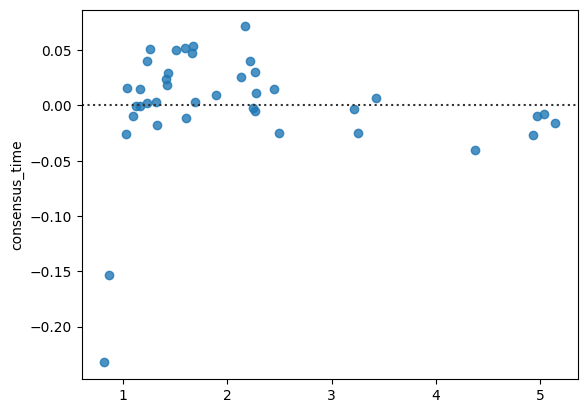

In [148]:
sns.residplot(x=y_pred, y=np.log1p(y_test))

Text(0, 0.5, 'log(Consensus Time)')

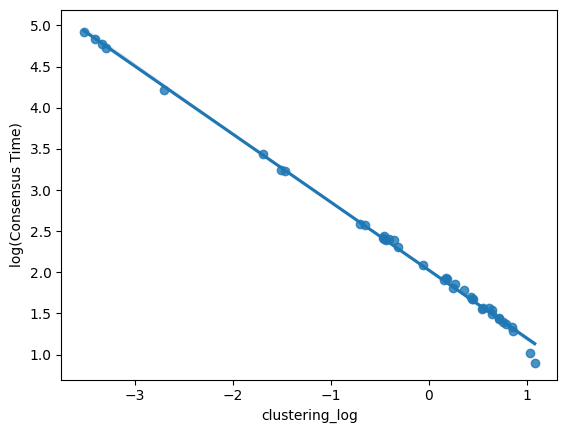

In [149]:
ax = sns.regplot(y=np.log1p(y_test), x=X_test['clustering_log'])
ax.set_ylabel('log(Consensus Time)')

## LASSO Regression
We intend to use Lasso for variable selection

In [86]:
from sklearn.linear_model import LassoCV

X_train[UNCORRELATED_FEATURE_SUBSET] = scaler.fit_transform(X_train[UNCORRELATED_FEATURE_SUBSET])
X_test[UNCORRELATED_FEATURE_SUBSET] = scaler.transform(X_test[UNCORRELATED_FEATURE_SUBSET])

lasso_cv = LassoCV(cv=20, random_state=0).fit(X_train[UNCORRELATED_FEATURE_SUBSET], np.log1p(y_train))

KeyError: "['assortativity', 'shannon_entropy'] not in index"

With fitted alpha, lets see statsmodels summary

In [ ]:
mod = sm.OLS(
    endog=np.log1p(y_train), 
    exog=sm.add_constant(X_train[UNCORRELATED_FEATURE_SUBSET]),
)
res = mod.fit_regularized(
    method='elastic_net',
    alpha=lasso_cv.alpha_,
    L1_wt=1,
    refit=True
)

KeyError: "['clustering', 'assortativity', 'shannon_entropy'] not in index"

In [ ]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         consensus_time   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.270e+04
Date:                Fri, 23 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:25:18   Log-Likelihood:                 278.91
No. Observations:                 446   AIC:                            -545.8
Df Residuals:                     441   BIC:                            -521.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.6197      0.006   10

In [ ]:
y_pred = res.predict(sm.add_constant(X_test[UNCORRELATED_FEATURE_SUBSET]))
adjusted_r2_score(y_pred, np.log1p(y_test), len(y_pred), len(UNCORRELATED_FEATURE_SUBSET))

0.9937404631731812

<Axes: ylabel='consensus_time'>

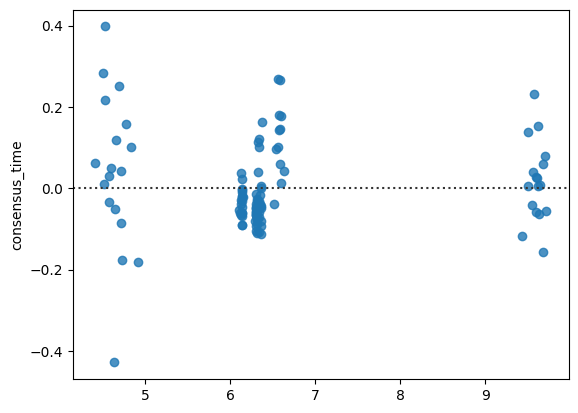

In [ ]:
sns.residplot(x=y_pred, y=np.log1p(y_test))